# **Modelo Predictivo para Estimar el Puntaje APGAR a los 5 Minutos**

Este notebook desarrolla un modelo predictivo avanzado para estimar el valor del puntaje APGAR a los 5 minutos (APGAR2), utilizando algoritmos de regresi√≥n supervisada.

Se aplican m√∫ltiples enfoques de modelado siguiendo los lineamientos requeridos:

- Validaci√≥n cruzada en el 70% de entrenamiento.

- Aplicaci√≥n de 4 modelos supervisados y 3 modelos de ensamble.

- Evaluaci√≥n con m√©tricas como MAE, RMSE, R¬≤ y MSE.

- Comparaci√≥n estad√≠stica mediante ANOVA y Tukey HSD.

- Selecci√≥n de los 3 mejores modelos para optimizaci√≥n de hiperpar√°metros.

El objetivo final es identificar el modelo m√°s preciso y robusto para ser llevado a producci√≥n.

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
# Cargar el dataset preparado en el notebook de limpieza de datos
df = pd.read_csv("df_limpio.csv")

df.head()

TIEMPO DE GESTACION  NUMERO CONSULTAS PRENATALES  APGAR1  APGAR2  \
0                 37.0                            7     9.0    10.0   
1                 40.0                            7     9.0    10.0   
2                 38.0                            7     9.0    10.0   
3                 38.0                            4     9.0    10.0   
4                 35.0                            4     9.0    10.0   

   TIPO PARTO_CESAREA  TIPO PARTO_ESPONTANEO  INDICE_MASA_NEONATAL  
0               False                   True              1.209194  
1               False                   True              1.441753  
2               False                   True              1.356017  
3               False                   True              1.242644  
4               False                   True              1.252028

In [3]:
# Separar las variables predictoras (X) de la variable objetivo (y)

X = df.drop(columns='APGAR2')
y = df['APGAR2']

# Dividir el conjunto de datos en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


APGAR2
10.0    4868
9.0     1433
8.0      481
7.0      128
6.0       50
5.0       31
4.0        8
1.0        6
3.0        3
2.0        2
Name: count, dtype: int64

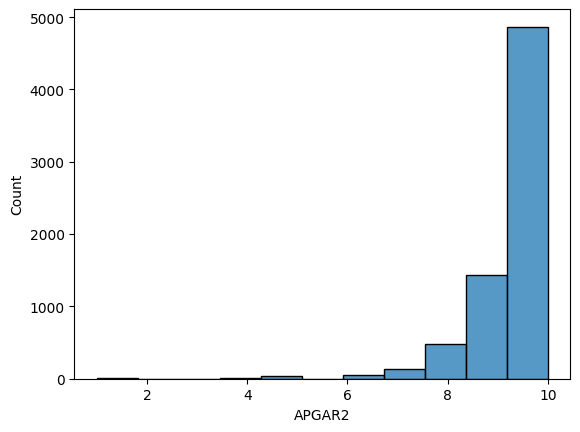

In [4]:
# Visualizar la distribuci√≥n de la variable objetivo en el conjunto de entrenamiento
sns.histplot(y_train, bins=11)
y_train.value_counts()

Aunque la variable objetivo APGAR2 presenta una distribuci√≥n altamente sesgada hacia los valores altos (especialmente 10 y 9), no se aplic√≥ ning√∫n m√©todo de balanceo. Esto se debe a que el problema es abordado como una tarea de regresi√≥n, y APGAR2 es una variable continua.

In [5]:

# Identificar las columnas num√©ricas para escalarlas
numeric_cols = X.select_dtypes(include='number').columns

# Inicializar el escalador y escalar solo las columnas num√©ricas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled = scaler.transform(X_test[numeric_cols])

# Convertir los arrays escalados de nuevo a DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_cols, index=X_test.index)

# Combinar las columnas escaladas con las columnas no num√©ricas
X_train_scaled = pd.concat([X_train_scaled, X_train.drop(columns=numeric_cols)], axis=1)
X_test_scaled = pd.concat([X_test_scaled, X_test.drop(columns=numeric_cols)], axis=1)


In [6]:
# Configurar la validaci√≥n cruzada con 10 particiones (K-Fold)
cv = KFold(n_splits=10, shuffle=True, random_state=42)

In [7]:
# Definir funci√≥n para evaluar modelos de regresi√≥n
def evaluar_modelos(modelos, X_train_scaled, y_train, X_test_scaled, y_test):
    resultados = []# Lista para guardar los resultados de cada modelo
    errores_individuales = []  # Para guardar errores absolutos por muestra

    for nombre, modelo in modelos.items():
        print(f"\n=== {nombre} ===")

        # Validaci√≥n cruzada sobre el conjunto de entrenamiento
        y_pred_cv = cross_val_predict(modelo, X_train_scaled, y_train, cv=cv)

        # Calcular m√©tricas de desempe√±o en validaci√≥n cruzada
        mae_cv = mean_absolute_error(y_train, y_pred_cv)
        mse_cv = mean_squared_error(y_train, y_pred_cv)
        rmse_cv = mse_cv ** 0.5
        r2_cv = r2_score(y_train, y_pred_cv)
        print(f"CV - MAE: {mae_cv:.3f}, RMSE: {rmse_cv:.3f}, R2: {r2_cv:.3f}")

        # Evaluar desempe√±o en el conjunto de prueba
        modelo.fit(X_train_scaled, y_train)
        y_pred_test = modelo.predict(X_test_scaled)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        mse_test = mean_squared_error(y_test, y_pred_test)
        rmse_test = mse_test ** 0.5
        r2_test = r2_score(y_test, y_pred_test)
        print(f"Test - MAE: {mae_test:.3f}, RMSE: {rmse_test:.3f}, R2: {r2_test:.3f}")

        # Guardar resultados del modelo
        resultados.append({
            "Modelo": nombre,
            "MAE_CV": mae_cv, "RMSE_CV": rmse_cv, "R2_CV": r2_cv,
            "MAE_Test": mae_test, "RMSE_Test": rmse_test, "R2_Test": r2_test
        })

        # Guardar errores absolutos individuales para ANOVA/Tukey
        errores = np.abs(y_test - y_pred_test)
        for e in errores:
            errores_individuales.append({"Modelo": nombre, "Error_Absoluto": e})

        # Graficar predicciones vs valores reales en test
        sns.scatterplot(x=y_test, y=y_pred_test)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Valor Real")
        plt.ylabel("Predicci√≥n")
        plt.title(f"Predicci√≥n vs Real - {nombre}")
        plt.show()

    # Crear DataFrames
    df_resultados = pd.DataFrame(resultados)
    df_errores = pd.DataFrame(errores_individuales)

    return df_resultados, df_errores

# **MODELOS SUPERVISADOS**

En esta etapa se aplican cuatro algoritmos de regresi√≥n supervisada para predecir el puntaje APGAR2: SVR (Support Vector Regressor), MLP Regressor (red neuronal), K-Nearest Neighbors (KNN) y √Årbol de Decisi√≥n.

In [8]:
# Definir modelos de aprendizaje supervisado
modelos_supervisados = {
    'SVR': SVR(),
    'MLP Regressor': MLPRegressor(max_iter=1000, random_state=42),
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}


=== SVR ===
CV - MAE: 0.313, RMSE: 0.573, R2: 0.589
Test - MAE: 0.307, RMSE: 0.563, R2: 0.594


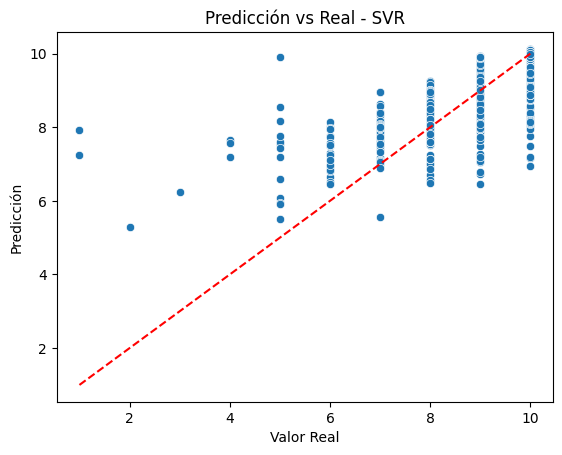


=== MLP Regressor ===
CV - MAE: 0.326, RMSE: 0.533, R2: 0.644
Test - MAE: 0.308, RMSE: 0.500, R2: 0.680


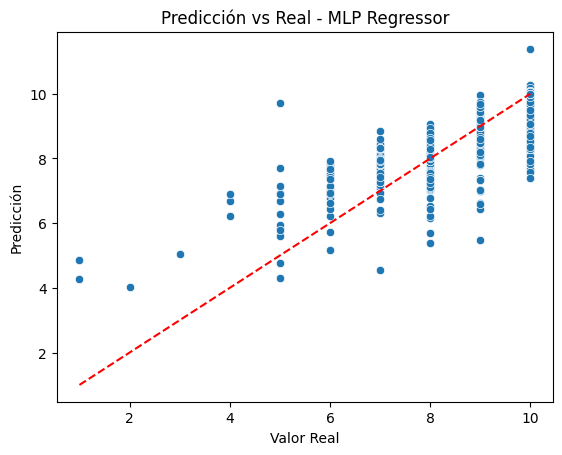


=== KNN ===
CV - MAE: 0.316, RMSE: 0.577, R2: 0.583
Test - MAE: 0.300, RMSE: 0.540, R2: 0.626


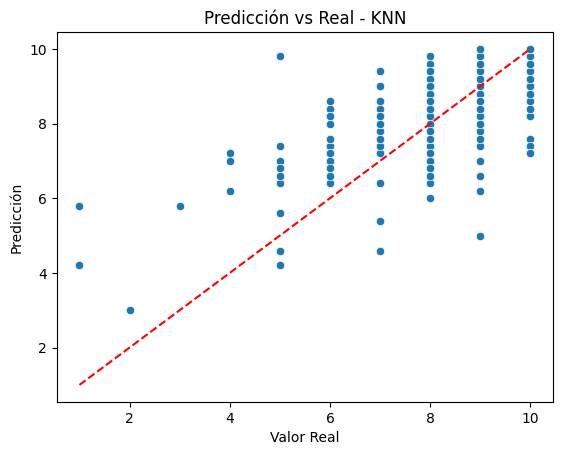


=== Decision Tree ===
CV - MAE: 0.342, RMSE: 0.745, R2: 0.305
Test - MAE: 0.316, RMSE: 0.719, R2: 0.339


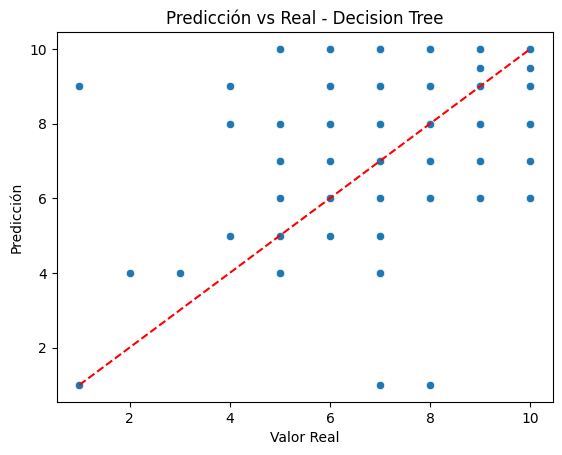

In [9]:
# Evaluar modelos supervisados
resultados_supervisados, errores_supervisados = evaluar_modelos(modelos_supervisados, X_train_scaled, y_train, X_test_scaled, y_test)

# **M√âTODOS DE ENSAMBLE**

Se implementan tres modelos de ensamble: Random Forest, Gradient Boosting y Bagging con √Årboles de Decisi√≥n.

In [10]:
# Definir modelos de aprendizaje supervisado

ensambles = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Bagging (Tree)": BaggingRegressor(estimator=DecisionTreeRegressor(), random_state=42)
}


=== Random Forest ===
CV - MAE: 0.311, RMSE: 0.565, R2: 0.601
Test - MAE: 0.296, RMSE: 0.546, R2: 0.618


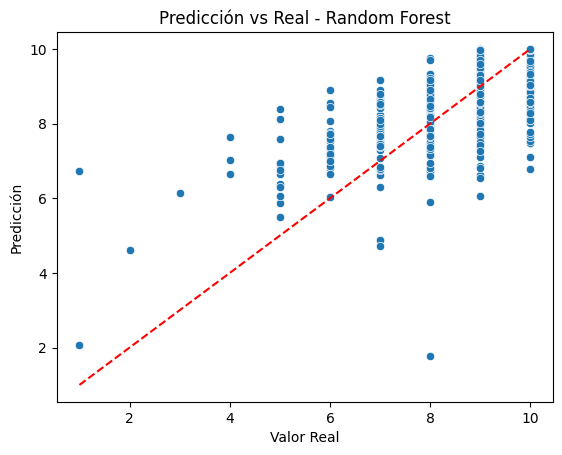


=== Gradient Boosting ===
CV - MAE: 0.315, RMSE: 0.531, R2: 0.647
Test - MAE: 0.305, RMSE: 0.530, R2: 0.640


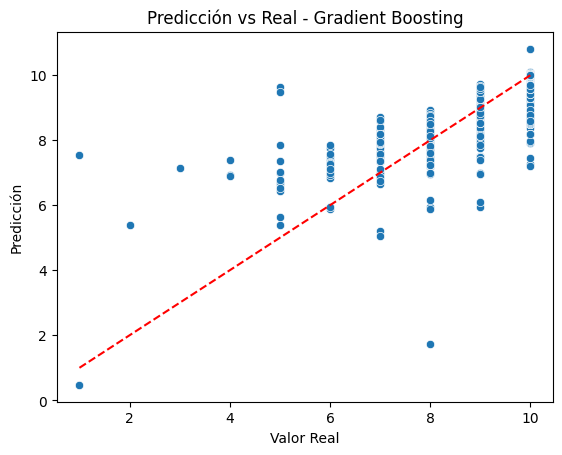


=== Bagging (Tree) ===
CV - MAE: 0.311, RMSE: 0.580, R2: 0.580
Test - MAE: 0.300, RMSE: 0.562, R2: 0.596


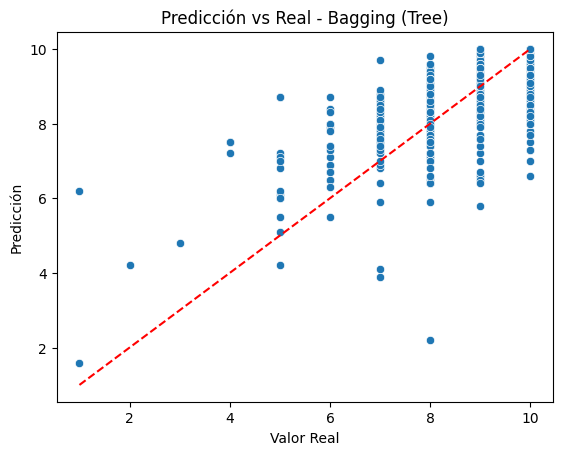

In [11]:
# Evaluar modelos de ensamble
resultados_ensamble, errores_ensamble = evaluar_modelos(ensambles, X_train_scaled, y_train, X_test_scaled, y_test)

**Interpretaci√≥n de m√©tricas obtenidas por los modelos**

Para evaluar el rendimiento de los modelos de regresi√≥n en la predicci√≥n del puntaje APGAR a los 5 minutos (APGAR2), se utilizaron cuatro m√©tricas clave:

MAE (Mean Absolute Error): representa el error promedio absoluto entre las predicciones y los valores reales. Indica, en promedio, cu√°ntos puntos se equivoca el modelo al predecir.

RMSE (Root Mean Squared Error): penaliza m√°s los errores grandes y ayuda a identificar qu√© tan dispersos son los errores del modelo.

R¬≤ (Coeficiente de determinaci√≥n): mide qu√© porcentaje de la variaci√≥n en el valor real (APGAR2) es explicado por el modelo. Un valor m√°s alto indica mejor capacidad predictiva.

A continuaci√≥n, se interpreta el desempe√±o de cada modelo seg√∫n los resultados en el conjunto de prueba:

üîπ MLP Regressor

- R¬≤ = 0.644 ‚Üí El modelo explica el 64% de la variabilidad de APGAR2.

- MAE = 0.326 ‚Üí En promedio, se equivoca por 0.33 puntos.

- RMSE = 0.533 ‚Üí Los errores son consistentes y no extremos.

üîπ Gradient Boosting

- R¬≤ = 0.647 ‚Üí Explica el 65% de la variabilidad.

- MAE = 0.315 ‚Üí Muy buen nivel de precisi√≥n promedio.

- RMSE = 0.531 ‚Üí Tiene algunos errores m√°s grandes, pero no graves.

üîπ KNN Regressor

- R¬≤ = 0.583 ‚Üí Explica el 58.3% de la variabilidad.

- MAE = 0.316 ‚Üí Es el que menos se equivoca en promedio.

- RMSE = 0.577 ‚Üí Tiene algunos errores altos que elevan el promedio cuadr√°tico.

üîπ Random Forest

- R¬≤ = 0.601 ‚Üí Explica el 60.1% de la variabilidad.

- MAE = 0.311 ‚Üí Gran precisi√≥n promedio.

- RMSE = 0.565 ‚Üí Algunos errores son m√°s dispersos.

üîπ Bagging con √Årboles

- R¬≤ = 0.580 ‚Üí Explica casi el 58% de la variabilidad.

- MAE = 0.311 ‚Üí Buen nivel de precisi√≥n.

- RMSE = 0.580 ‚Üí Presencia de errores m√°s grandes en algunos casos.

üîπ SVR (Support Vector Regressor)

- R¬≤ = 0.589 ‚Üí Similar a Bagging en capacidad explicativa.

- MAE = 0.313 ‚Üí Error promedio moderado.

- RMSE = 0.573 ‚Üí Sensible a errores m√°s grandes.

üîª Decision Tree

- R¬≤ = 0.305 ‚Üí Solo explica el 30.5% de la variabilidad.

- MAE = 0.342 ‚Üí Error promedio m√°s alto.

- RMSE = 0.745 ‚Üí Muchos errores grandes, bajo rendimiento general.



In [12]:
# Combinar y mostrar resultados finales
todos_resultados = pd.concat([resultados_supervisados, resultados_ensamble], ignore_index=True)

# Mostrar como tabla
display(todos_resultados)

# Ordenar por R2 en test para ver el mejor modelo primero
print("\nModelos ordenados por desempe√±o en Test (R2):")
print(todos_resultados.sort_values(by="R2_Test", ascending=False))


Modelo    MAE_CV   RMSE_CV     R2_CV  MAE_Test  RMSE_Test  \
0                SVR  0.312713  0.572942  0.589439  0.307287   0.562936   
1      MLP Regressor  0.325548  0.533390  0.644167  0.307561   0.500348   
2                KNN  0.316291  0.577139  0.583402  0.300433   0.540192   
3      Decision Tree  0.342368  0.745409  0.305063  0.316473   0.718776   
4      Random Forest  0.310873  0.564992  0.600754  0.296128   0.546298   
5  Gradient Boosting  0.315064  0.531069  0.647258  0.304885   0.530486   
6     Bagging (Tree)  0.311459  0.579509  0.579974  0.299664   0.561512   

    R2_Test  
0  0.594353  
1  0.679539  
2  0.626470  
3  0.338671  
4  0.617977  
5  0.639771  
6  0.596403


Modelos ordenados por desempe√±o en Test (R2):
              Modelo    MAE_CV   RMSE_CV     R2_CV  MAE_Test  RMSE_Test  \
1      MLP Regressor  0.325548  0.533390  0.644167  0.307561   0.500348   
5  Gradient Boosting  0.315064  0.531069  0.647258  0.304885   0.530486   
2                KNN  0.316291  0.577139  0.583402  0.300433   0.540192   
4      Random Forest  0.310873  0.564992  0.600754  0.296128   0.546298   
6     Bagging (Tree)  0.311459  0.579509  0.579974  0.299664   0.561512   
0                SVR  0.312713  0.572942  0.589439  0.307287   0.562936   
3      Decision Tree  0.342368  0.745409  0.305063  0.316473   0.718776   

    R2_Test  
1  0.679539  
5  0.639771  
2  0.626470  
4  0.617977  
6  0.596403  
0  0.594353  
3  0.338671  


**Interpretaci√≥n del an√°lisis estad√≠stico (ANOVA y Tukey)**

Para determinar si exist√≠an diferencias estad√≠sticamente significativas entre los modelos aplicados al problema de predicci√≥n de APGAR2, se aplicaron dos pruebas:

1. ANOVA (An√°lisis de Varianza)
El objetivo de esta prueba fue comparar los errores absolutos individuales obtenidos por cada modelo en el conjunto de prueba.

F-statistic: 0.5837

p-value: 0.7437

El valor-p es mucho mayor que 0.05, lo que indica que no hay evidencia estad√≠sticamente significativa para afirmar que existen diferencias entre los errores de los modelos evaluados.

2. Tukey HSD (Prueba de comparaciones m√∫ltiples)
Esta prueba se aplic√≥ para identificar si existen diferencias significativas entre pares espec√≠ficos de modelos.

Todos los valores de reject en la tabla son False, lo que confirma que ninguna diferencia entre modelos es estad√≠sticamente significativa.

Los intervalos de confianza para las diferencias de medias de error siempre incluyen el 0, y los valores p-adj son todos muy superiores a 0.05.

Conclusi√≥n
Aunque algunos modelos obtuvieron mejores m√©tricas (como menor MAE o mayor R¬≤), estad√≠sticamente, no se detectaron diferencias significativas entre sus desempe√±os en t√©rminos de error absoluto. Esto sugiere que, desde una perspectiva estad√≠stica, los 7 modelos tienen un comportamiento comparativamente similar al predecir APGAR2 en el conjunto de prueba.

Sin embargo, por razones pr√°cticas y de interpretaci√≥n, es mejor seleccionar los modelos con mejor combinaci√≥n de MAE bajo, RMSE bajo y R¬≤ alto, como lo son en este caso:

**MLP Regressor, Gradient Boosting y KNN Regressor**

In [13]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [14]:
errores_individuales = pd.concat([errores_supervisados, errores_ensamble], ignore_index=True)

In [15]:
# Agrupar errores por modelo
grupos = [errores_individuales[errores_individuales['Modelo'] == m]['Error_Absoluto']
          for m in errores_individuales['Modelo'].unique()]

# Prueba ANOVA
anova = f_oneway(*grupos)

print("=== ANOVA ===")
print(f"F-statistic: {anova.statistic:.4f}")
print(f"p-value: {anova.pvalue:.4f}")

=== ANOVA ===
F-statistic: 0.5849
p-value: 0.7427


In [16]:
# Tukey HSD
tukey = pairwise_tukeyhsd(endog=errores_individuales['Error_Absoluto'],
                          groups=errores_individuales['Modelo'],
                          alpha=0.05)

print("\n=== Tukey HSD ===")
print(tukey.summary())



=== Tukey HSD ===
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
      group1            group2      meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------
   Bagging (Tree)     Decision Tree   0.0168 0.8263 -0.0198 0.0534  False
   Bagging (Tree) Gradient Boosting   0.0052 0.9996 -0.0314 0.0418  False
   Bagging (Tree)               KNN   0.0008    1.0 -0.0358 0.0374  False
   Bagging (Tree)     MLP Regressor   0.0079 0.9956 -0.0287 0.0445  False
   Bagging (Tree)     Random Forest  -0.0035    1.0 -0.0401 0.0331  False
   Bagging (Tree)               SVR   0.0076 0.9964  -0.029 0.0442  False
    Decision Tree Gradient Boosting  -0.0116 0.9673 -0.0482  0.025  False
    Decision Tree               KNN   -0.016  0.856 -0.0527 0.0206  False
    Decision Tree     MLP Regressor  -0.0089 0.9916 -0.0455 0.0277  False
    Decision Tree     Random Forest  -0.0203 0.6572  -0.057 0.0163  False
    Decision Tree  

/usr/local/lib/python3.11/dist-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


**Elecci√≥n de los mejores 3 modelos**

Para poder elegir correctamete los 3 mejores modelos, se deben de tener en cuenta las metricas de evaluaci√≥n que se realizaron anteriormente, en donde, el valor de R^2 debe ser alto, el valor del MAE debe de ser m√°s bajo y el valor del MAPE debe de ser bajo.
Los modelos que cumplen con las metricas y sus valores mencionados anteriormente son los siguiente:


*   MLP Regressor
*   Gradient Boosting

*   Random Forest Regressor

Por ende estos son los mejores 3 modelos que predicen nuestra varibale objetivo





In [18]:
#Busqueda de hiperparametros por GridSearch
#Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

gb = GradientBoostingRegressor(random_state=42)
grid_gb = GridSearchCV(gb, param_grid=param_grid_gb, cv=10, scoring='r2', n_jobs=-1)
grid_gb.fit(X_train, y_train)

print("Mejores par√°metros GB:", grid_gb.best_params_)


Mejores par√°metros GB: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


In [19]:
#MLP Regressor
from sklearn.neural_network import MLPRegressor

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPRegressor(max_iter=1000, random_state=42)
grid_mlp = GridSearchCV(mlp, param_grid=param_grid_mlp, cv=10, scoring='r2', n_jobs=-1)
grid_mlp.fit(X_train, y_train)

print("Mejores par√°metros MLP:", grid_mlp.best_params_)


Mejores par√°metros MLP: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [20]:
#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(rf, param_grid=param_grid_rf, cv=10, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Mejores par√°metros RF:", grid_rf.best_params_)


Mejores par√°metros RF: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


**Elecci√≥n del mejor modelo con los mejores parametros**

De los mejores 3 modelos que se eligieron posteriormente, se debe de elegir el mejor para as√≠ poderlo llevar a despligue con sus mejores parametro, por ende a esos tres modelos se les aplicar√° el metodo de evaluaci√≥n que se realiz√≥ anteriormente cuando se ten√≠an todos los modelos, en donde evaluaremos las metrias de R^2, MAE y MAPE

In [32]:
#Entrenamos los modelos con los mejores hiperparametros
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor

#Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(
    learning_rate=0.01,
    max_depth=3,
    n_estimators=300,
    subsample=0.8,
    random_state=42
)

In [33]:
#MLP Regressor
mlp_model = MLPRegressor(
    activation='tanh',
    alpha=0.0001,
    hidden_layer_sizes=(50, 50),
    learning_rate='constant',
    solver='adam',
    max_iter=1000,
    random_state=42
)

In [34]:
#Random Forest Regressor
rf_model = RandomForestRegressor(
    bootstrap=True,
    max_depth=10,
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=200,
    random_state=42
)

In [35]:
# Entrena los modelos
gb_model.fit(X_train, y_train)
mlp_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200, random_state=42)

In [36]:
#Evaluamos los modelos en el conjunto de prueba
modelos = {
    'Gradient Boosting': gb_model,
    'MLP Regressor': mlp_model,
    'Random Forest': rf_model
}

resultados = []

for nombre, modelo in modelos.items():
    y_pred = modelo.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    resultados.append({
        'Modelo': nombre,
        'R2': round(r2, 4),
        'MAE': round(mae, 4),
        'RMSE': round(rmse, 4)
    })

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by='R2', ascending=False)
print(df_resultados)

              Modelo      R2     MAE    RMSE
1      MLP Regressor  0.6664  0.3337  0.5105
0  Gradient Boosting  0.6651  0.3119  0.5115
2      Random Forest  0.6484  0.2962  0.5241


**Mejor modelo**

Teniendo en cuenta las metricas de evaluaci√≥n, el modelo que tiene mejor R^2 es el MLP Regressor (m√°s alto mejor), el modelo que tiene mejor MAE es el Random Forest (m√°s bajo mejor) y el modelo que tine el mejor RMSE es el MLP Regressor.
El mejor modelo es el MLP Regresor ya que este tiene mejores valores de R^2 y RMSE, lo que indica que generaliza mejor pero tiene m√°s error ya que tiene el RMSE alto pero es el m√°s bajo de los 3.

In [38]:
#Guardamos el mejor modelo
import joblib
joblib.dump(mlp_model, 'modelo_mlp_final.pkl')


['modelo_mlp_final.pkl']